In [92]:
print("Hello World")

Hello World


In [93]:
import os

from dotenv import load_dotenv

load_dotenv()

os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")

In [94]:
os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

from langchain.chat_models import init_chat_model

llm = init_chat_model(
    "gemini-2.0-flash",
    model_provider="google_genai",
)

llm.invoke("What is the capital of France?")

AIMessage(content='The capital of France is **Paris**.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--45284f7a-8a3f-462f-912f-0f0f93730bff-0', usage_metadata={'input_tokens': 7, 'output_tokens': 9, 'total_tokens': 16, 'input_token_details': {'cache_read': 0}})

In [95]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [96]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [97]:
import bs4

from langchain_community.document_loaders import WebBaseLoader

bs4_strainer = bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)

docs = loader.load()

assert len(docs) == 1

print(f"Total chunks: {len(docs[0].page_content)}")

Total chunks: 43047


In [98]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [99]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, 
    chunk_overlap=200,
    add_start_index=True,
)


all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents")

Split blog post into 63 sub-documents


In [100]:
documents_ids = vector_store.add_documents(all_splits)

print(documents_ids[:3])

['48b0593f-0a9e-4cb5-8716-da0f012c7605', '8b9ec86a-e5b5-40c6-aaaf-66649a40b51e', 'a4fe5e1c-7375-4d8f-8153-b29300f63e14']


In [101]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {
        "context": "(context goes here)",
        "question": "(question goes here)",
    }
).to_messages()

assert len(example_messages) == 1

print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [102]:
from typing import List, TypedDict

from langchain_core.documents import Document


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


In [103]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join([doc.page_content for doc in state["context"]])
    messages = prompt.invoke(
        {
            "context": docs_content,
            "question": state["question"],
        }
    )
    response = llm.invoke(messages)
    return {"answer": response.content}


In [104]:
from langgraph.graph import StateGraph, START


graph_builder = StateGraph(State).add_sequence([retrieve, generate])

graph_builder.add_edge(START, "retrieve")

graph = graph_builder.compile()

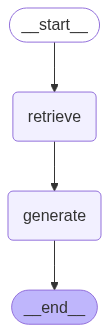

In [105]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [106]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}')
print(f'Answer: {result["answer"]}')

Context: [Document(id='c22a5dd7-0824-4bbd-aea0-612176c231be', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool,

In [107]:
for step in graph.stream({"question": "What is Task Decomposition?"}, stream_mode="updates"):
    print(f"{step}\n\n--------------------------------\n\n")

{'retrieve': {'context': [Document(id='c22a5dd7-0824-4bbd-aea0-612176c231be', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to a

In [108]:
for message, metadata in graph.stream({"question": "What is Task Decomposition?"}, stream_mode="messages"):
    print(message.content, end="|")

Task| decomposition involves| breaking down a complex task into smaller, more manageable steps. This can be achieved| through LLMs with simple prompting, task-specific instructions, or human input. It| is a crucial component in planning, as it helps agents understand and plan ahead for complicated tasks.
|

In [109]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [110]:
total_documents = len(all_splits)

third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [111]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

_ = vector_store.add_documents(all_splits)


In [112]:
from typing import Annotated, TypedDict
from typing_extensions import Literal

class Search(TypedDict):
    """Search Query."""

    query: Annotated[str,..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]


In [113]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata["section"] == query["section"],
        )
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join([doc.page_content for doc in state["context"]])
    messages = prompt.invoke(
        {
            "context": docs_content,
            "question": state["question"],
        }
    )
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query,retrieve, generate])

graph_builder.add_edge(START, "analyze_query")

graph = graph_builder.compile()

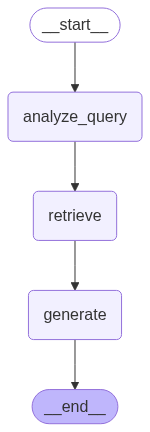

In [114]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [115]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'section': 'end', 'query': 'Task Decomposition'}}}

----------------

{'retrieve': {'context': [Document(id='e01d755e-3416-4492-8969-7083c9605b85', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 32987, 'section': 'end'}, page_content='You will get instructions for code to write.\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\nMake sure that every detail of the architecture is, in the end, implemented as code.\nThink step by step and reason yourself to the right decisions to make sure we get it right.\nYou will first lay out the names of the core classes, functions, methods that will be necessary, as well as a quick comment on their purpose.\nThen you will output the content of each file including ALL code.\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\nFILENAME is the lowe

# RAG 2

In [116]:
from langgraph.graph import StateGraph, MessagesState
graph_builder = StateGraph(MessagesState)

In [117]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to the query"""
    retrived_docs = vector_store.similarity_search(query,k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrived_docs
    )
    return serialized, retrived_docs

In [121]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import END
from langchain_core.messages import SystemMessage



def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond"""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

tools = ToolNode([retrieve])

def generate(state: MessagesState):
    """Generate answer."""
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)

    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )

    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human","system")
        or (message.type == "ai" and not message.tool_calls)
    ]

    prompt = [SystemMessage(system_message_content)] + conversation_messages

    response = llm.invoke(prompt)
    return {"messages": [response]}


graph_builder = StateGraph(MessagesState)
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)


graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)

graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()



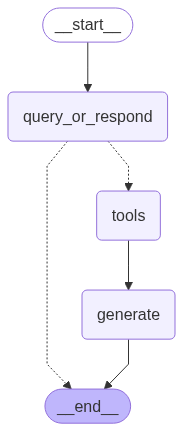

In [119]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [122]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [123]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (58125f9e-3157-48fa-9efb-3eb488b2a4f5)
 Call ID: 58125f9e-3157-48fa-9efb-3eb488b2a4f5
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578, 'section': 'beginning'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Def

In [124]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

In [125]:
config = {"configurable": {"thread_id": "1"}}

In [126]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (5902c29a-f22e-40b8-8adc-5e6ee19cbe36)
 Call ID: 5902c29a-f22e-40b8-8adc-5e6ee19cbe36
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578, 'section': 'beginning'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Def

In [127]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (4b7d3156-86be-4958-ac03-ef69f65f9df9)
 Call ID: 4b7d3156-86be-4958-ac03-ef69f65f9df9
  Args:
    query: common methods for task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578, 'section': 'beginning'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This appr

In [128]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)



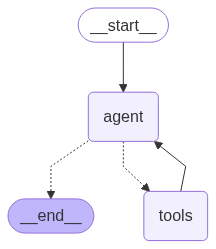

In [129]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [130]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (5ad09e6f-65a2-4fd1-8aad-09faf02abed9)
 Call ID: 5ad09e6f-65a2-4fd1-8aad-09faf02abed9
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578, 'section': 'beginning'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves rely